# Training Flows with log-Determinant

In [1]:
import os
import sys
import time
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from scipy.special import softmax

import utils
from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_prob_simplex

### Generate fake target distribution and simulated predictions

In [2]:
n_samples = 1500

target = np.array(random.choices(range(3), k=n_samples))
one_hot = onehot_encode(target)

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.05

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.7 + np.random.randn(n_samples)*0.1

logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset)

# 0-center logits
logits -= np.mean(logits, axis=1, keepdims=True)

probs = softmax(logits, axis=1)

nll = neg_log_likelihood(probs, target)
ECE = expected_calibration_error(probs, target)

print("Negative log-likelihood of the classifier predictions: {:.5f}".format(nll))
print("Expected Calibration Error of the classifier predictions: {:.5f}".format(ECE))

Negative log-likelihood of the classifier predictions: 0.81397
Expected Calibration Error of the classifier predictions: 0.29589


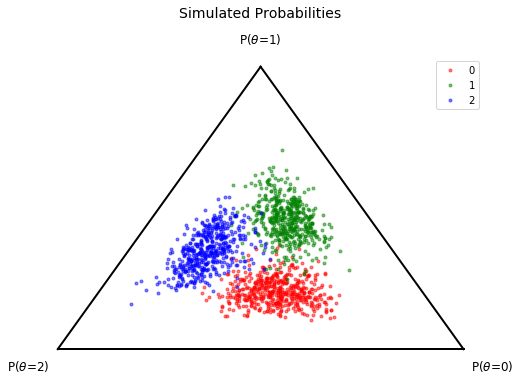

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = plot_prob_simplex(probs, target, ax=ax, title='Simulated Probabilities')

plt.show()

## Define Affine flow

In [4]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_size=[], activation=F.relu):
        super(MLP, self).__init__()
        self.activation = activation
        units = [dim] + hidden_size + [dim]
        self.layers = nn.ModuleList([nn.Linear(units[i], units[i+1])
                                     for i in range(len(units)-1)])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        y = self.layers[-1](x)

        return y

In [5]:
class AffineConstantLayer(nn.Module):

    def __init__(self, dim, scale=True, shift=True):
        super(AffineConstantLayer, self).__init__()

        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if scale else None
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if shift else None

    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        z = x * torch.exp(s) + t
        log_det = torch.sum(s, dim=1)
        return z, log_det

    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [6]:
class NvpCouplingLayer(nn.Module):
    def __init__(self, dim):
        super(NvpCouplingLayer, self).__init__()
        self.s = MLP(dim, [5, 5])
        self.t = MLP(dim, [5, 5])
        
        # Use random partitioning of the data
        mask = np.random.randint(2, size=dim)
        while mask.sum() < 1 or mask.sum() == dim:
            mask = np.random.randint(2, size=dim)
            
        self.mask = nn.Parameter(
                torch.as_tensor(mask.copy(), dtype=torch.float),
                requires_grad=False)

    def forward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1 * (x * torch.exp(s) + t)

        log_det = torch.sum(b_1*s, dim=1)

        return y, log_det.squeeze()

    def backward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1*((x - t) * torch.exp(-s))

        log_det = torch.sum(b_1*(-s), dim=1)

        return y, log_det.squeeze()

In [7]:
class Flow(nn.Module):
    def __init__(self, layers, **kwargs):
        super(Flow, self).__init__()

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        cum_log_det = torch.zeros(x.shape[0])
        for layer in self.layers:
            x, log_det = layer(x)
            cum_log_det += log_det

        return x, cum_log_det

## Train flow

We introduce the parameter $\gamma$ to control the contribution of the log-determinant to the loss:

In [8]:
epochs = 1000
layers = 10


# Convert data to torch tensors.
torch_logits = torch.as_tensor(logits, dtype=torch.float)
torch_target = torch.as_tensor(target, dtype=torch.long)

# Values of gamma to use
gammas = [
    lambda x: 0.,
    lambda x: 1.,
    lambda x: min(1, 0.01 + x/1000),
]

labels = [
    '0',
    '1',
    r'min(1, 0.01 + e/1000)',
]

In [9]:
def train_model(gamma):
    # Build  flow
    flow_layers = [NvpCouplingLayer(3) for _ in range(layers)]
    model = Flow(layers=flow_layers)
    
    # Instantiate optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters())
    CE = nn.CrossEntropyLoss()
    
    loss = []
    ce = []
    logdet = []
    
    # Train loop
    for e in range(epochs):
        preds, _logdet = model(torch_logits)

        _ce = CE(preds, torch_target)
        _loss = _ce - gamma(e)*torch.mean(_logdet)

        loss.append(_loss.item())
        ce.append(_ce.item())
        logdet.append(torch.mean(_logdet).item())

        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()
        
    probs = softmax(model(torch_logits)[0].detach().numpy(), axis=1)

    nll = neg_log_likelihood(probs, target)
    ECE = expected_calibration_error(probs, target)
        
    return {
        'model': model,
        'loss': loss,
        'ce': ce,
        'logdet': logdet,
        'NLL': nll,
        'ECE': ECE
    }

**Train flows:**

In [10]:
models = [train_model(gamma) for gamma in gammas]

..\utils\metrics.py:63: RuntimeWarning: invalid value encountered in greater
  idx = np.where((low < probs) & (probs <= high))
..\utils\metrics.py:63: RuntimeWarning: invalid value encountered in less_equal
  idx = np.where((low < probs) & (probs <= high))


### Some plots:

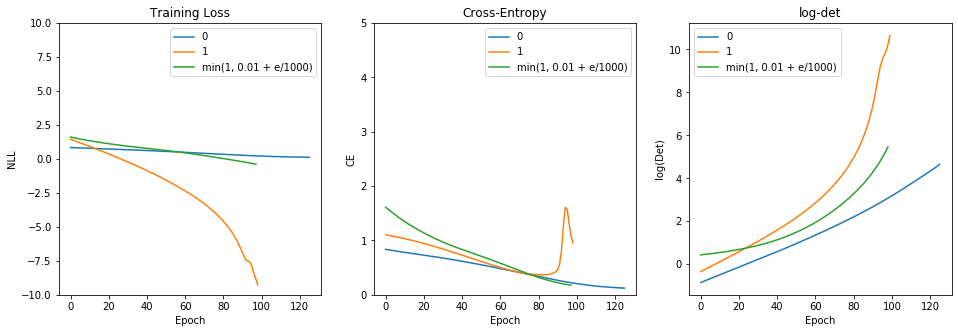

In [11]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

for i, model in enumerate(models):
    label = labels[i]
    ax[0].plot(model['loss'], label=label)
    ax[1].plot(model['ce'], label=label)
    ax[2].plot(model['logdet'], label=label)


ax[0].set_title('Training Loss')
ax[0].set_ylabel('NLL')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim([-10, 10])
ax[0].legend()

ax[1].set_title('Cross-Entropy')
ax[1].set_ylabel('CE')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim([0, 5])
ax[1].legend()

ax[2].set_title('log-det')
ax[2].set_ylabel('log(Det)')
ax[2].set_xlabel('Epoch')
ax[2].legend()

plt.show()

In [12]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height.
    Taken from:
    'https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py'
    
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

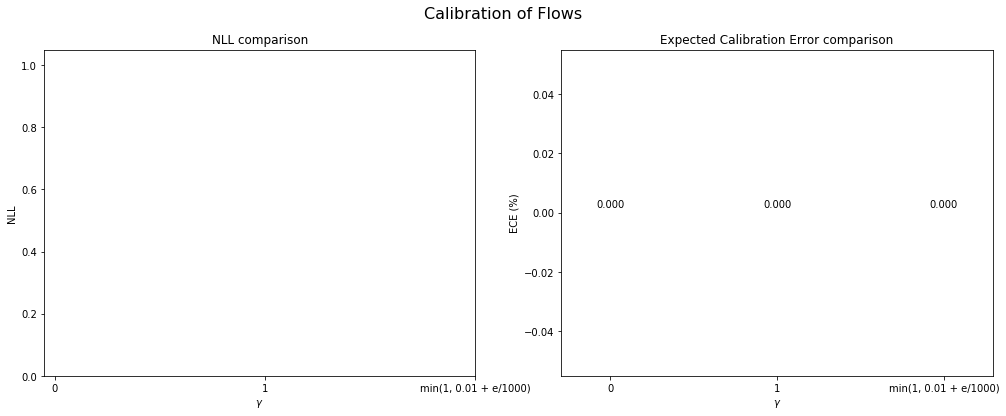

In [13]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
fig.suptitle('Calibration of Flows', fontsize=16)


ind = np.arange(len(gammas))
width = 0.35


rects = ax_arr[0].bar(ind, [model['NLL'] for model in models], width, color='b')

ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_xlabel('$\gamma$')
ax_arr[0].set_title('NLL comparison')
ax_arr[0].set_xticks(ind)
ax_arr[0].set_xticklabels(labels)

autolabel(rects, ax_arr[0])


rects = ax_arr[1].bar(ind, [model['ECE']*100 for model in models], width, color='b')

ax_arr[1].set_ylabel('ECE (%)')
ax_arr[1].set_xlabel('$\gamma$')
ax_arr[1].set_title('Expected Calibration Error comparison')
ax_arr[1].set_xticks(ind)
ax_arr[1].set_xticklabels(labels)

autolabel(rects, ax_arr[1])

plt.show()

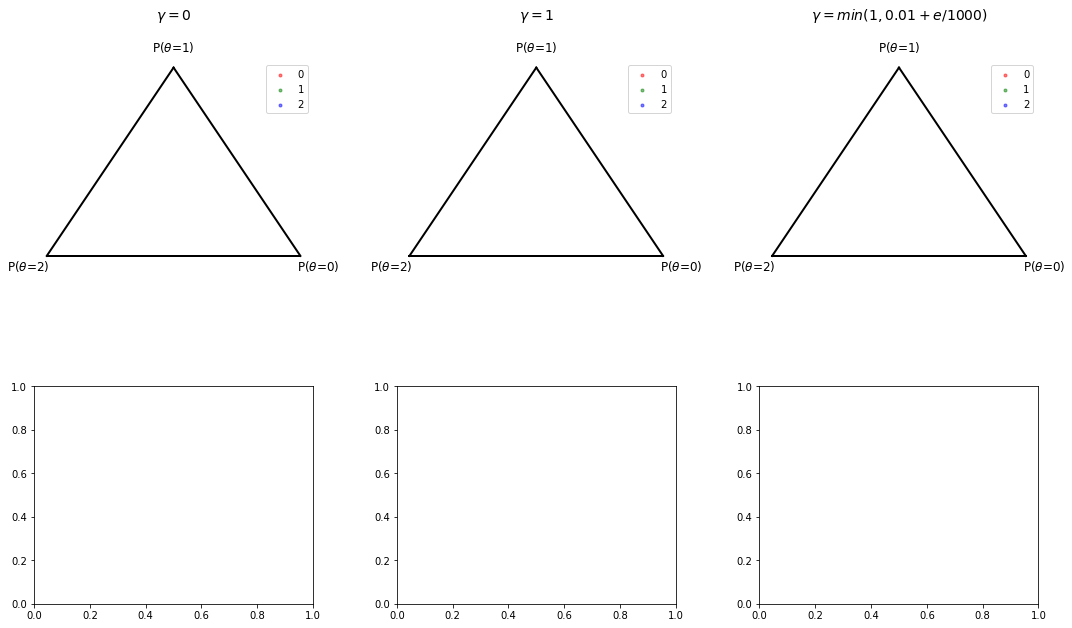

In [14]:
fig, ax_arr = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

for i, model in enumerate(models):

    probs = softmax(model['model'](torch_logits)[0].detach().numpy(), axis=1)
    label = r'$\gamma = {}$'.format(labels[i])
    ax_arr[i//3, i%3] = plot_prob_simplex(probs, target=target, ax=ax_arr[i//3, i%3], title=label)
    
plt.show()

In [26]:
models[0]['model'].layers[9].mask

Parameter containing:
tensor([1., 0., 0.])